In [129]:
from time import time
from PIL import Image
import torch
from transformers import AutoImageProcessor, AutoModel

# Load Dinov2 processor and model
# Available size variants: "facebook/dinov2-small", "facebook/dinov2-base", "facebook/dinov2-large", "facebook/dinov2-giant"
# Change the model_name below to use a different size variant
model_name = "facebook/dinov2-base"
processor = AutoImageProcessor.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name).eval().to(torch.device('cuda')).half()

# Load your images
# image1 = Image.open("datasets/mono/MH004/000002.png").convert("RGB")
image1 = Image.open("datasets/mono/MH007/000930.png").convert("RGB")
image2 = Image.open("datasets/TartanAir/AbandonedFactory/P001/image_left/000002_left.png").convert("RGB")


inputs = processor([image1], return_tensors="pt")
inputs = {k: (v.to(model.device).half() if isinstance(v, torch.Tensor) else v) for k, v in inputs.items()}

## Warmup 
for i in range(5):
    _ = model(**inputs)


torch.cuda.synchronize()
import time
t0 = time.perf_counter()
with torch.no_grad():
    outputs = model(**inputs)



# reshape patch tokens (exclude [CLS]) into a spatial feature map B x C x H x W
patch_tokens = outputs.last_hidden_state[:, 1:, :]  # (B, N_patches, C)
B, N, C = patch_tokens.shape
print(B, N, C)
H = W = int(N ** 0.5)
feature_map = patch_tokens.transpose(1, 2).reshape(B, C, H, W)

# keep for downstream use if needed
embeddings = feature_map
t1 = time.perf_counter()
torch.cuda.synchronize()
print("Inference Time: {:.5f} seconds".format(t1 - t0))
print(feature_map.shape)

1 256 768
Inference Time: 0.00230 seconds
torch.Size([1, 768, 16, 16])


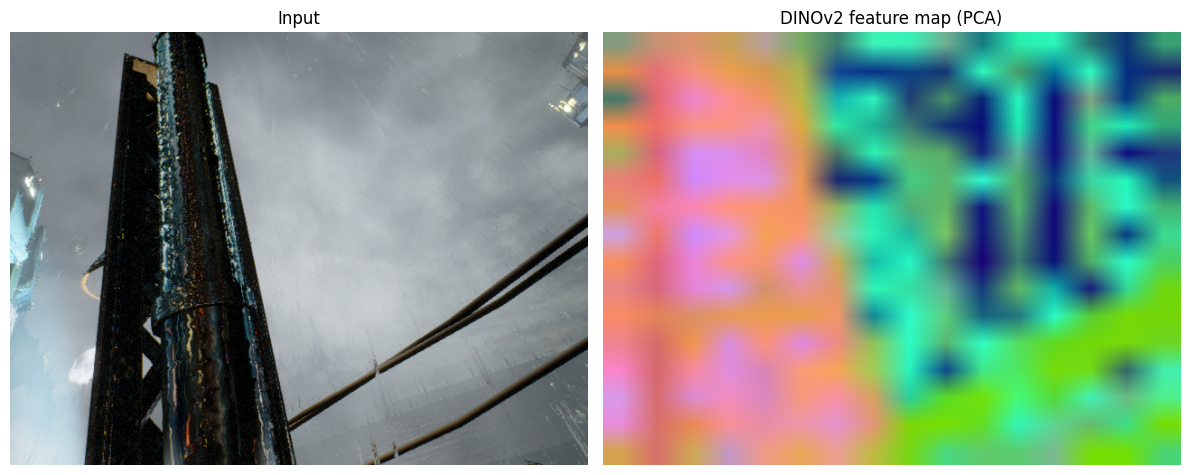

In [12]:
# Visualize DINOv2 feature map (PCA to RGB), upsampled to image1 size
import matplotlib.pyplot as plt
# pick the 4D feature map tensor
try:
    fmap4d = embeddings  # (B, C, H, W) from cell 0
except NameError:
    fmap4d = feature_map

with torch.no_grad():
    fmap = fmap4d[0].detach().float().cpu()  # C x h x w
    C, h, w = fmap.shape

    # flatten spatial dims and center features
    x = fmap.permute(1, 2, 0).reshape(-1, C)
    x = x - x.mean(0, keepdim=True)

    # project to 3 components (PCA via pca_lowrank)
    _, _, V = torch.pca_lowrank(x, q=3, center=False)
    x3 = x @ V[:, :3]

    # per-channel min-max normalization to [0,1]
    mins = x3.min(0, keepdim=True).values
    maxs = x3.max(0, keepdim=True).values
    x3 = (x3 - mins) / (maxs - mins + 1e-6)

    # reshape to image and upsample to input image size
    rgb = x3.reshape(h, w, 3).permute(2, 0, 1).unsqueeze(0)  # 1x3xhxw
    rgb_up = torch.nn.functional.interpolate(
        rgb, size=image1.size[::-1], mode="bilinear", align_corners=False
    ).squeeze(0).permute(1, 2, 0).clamp(0, 1).numpy()

# show input and feature map
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(image1)
ax[0].set_title("Input")
ax[0].axis("off")

ax[1].imshow(rgb_up)
ax[1].set_title("DINOv2 feature map (PCA)")
ax[1].axis("off")

plt.tight_layout()
plt.show()

## Maskformer Instance Segmentation

/home/user/anaconda3/envs/dpvo118_backup/lib/python3.10/site-packages/transformers/image_processing_base.py:417: UserWarning: The following named arguments are not valid for `Mask2FormerImageProcessor.__init__` and were ignored: '_max_size', 'reduce_labels'
  image_processor = cls(**image_processor_dict)


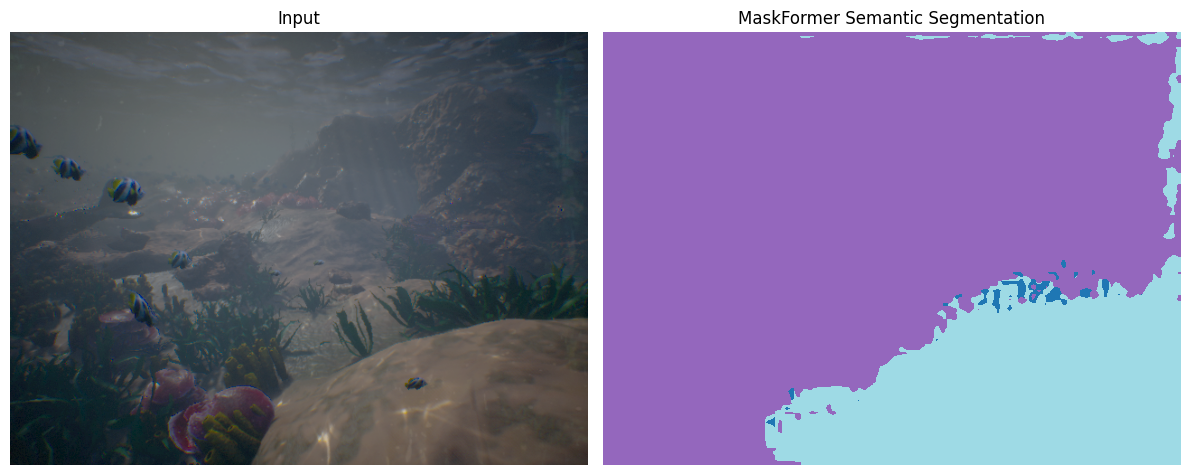

Unique class ids: [0, 33, 77]
Inference avg: 22.28 ms/img (44.87 FPS) over 20 runs


In [13]:
from transformers import Mask2FormerForUniversalSegmentation, AutoImageProcessor
import torch 
import matplotlib.pyplot as plt
from pathlib import Path

# Load MaskFormer model and processor (semantic segmentation on ADE20k)
seg_model_name = "facebook/mask2former-swin-large-coco-instance" ## Badddd
seg_processor = AutoImageProcessor.from_pretrained(seg_model_name)
seg_model = Mask2FormerForUniversalSegmentation.from_pretrained(seg_model_name).eval().to(torch.device('cuda'))


# image1 = Image.open("datasets/mono/ME001/000000.png").convert("RGB") ## Park/Tree/Day/Sunny
# image1 = Image.open("datasets/mono/ME000/000001.png").convert("RGB") ## Abonded Building terrace/ Day/very Sunny/glare
# image1 = Image.open("datasets/mono/ME002/000011.png").convert("RGB") ## cave/forest/dark
# image1 = Image.open("datasets/mono/ME003/000027.png").convert("RGB") ## suburban area/road/car/house
image1 = Image.open("datasets/mono/ME004/000020.png").convert("RGB") ## underwater


seg_inputs = seg_processor(images=image1, return_tensors="pt")
seg_inputs = {k: (v.to(seg_model.device) if isinstance(v, torch.Tensor) else v) for k, v in seg_inputs.items()}

with torch.no_grad():
    seg_outputs = seg_model(**seg_inputs)

# Post-process to obtain semantic segmentation mask at image resolution
seg_result = seg_processor.post_process_semantic_segmentation(
    outputs=seg_outputs, target_sizes=[image1.size[::-1]]
)[0]  # (H, W) tensor with class ids

# Visualize input and segmentation mask
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(image1)
ax[0].set_title("Input")
ax[0].axis("off")

ax[1].imshow(seg_result.cpu(), cmap="tab20", interpolation="nearest")
ax[1].set_title("MaskFormer Semantic Segmentation")
ax[1].axis("off")

plt.tight_layout()
plt.show()

# Optional: print unique class ids present
print("Unique class ids:", sorted(set(seg_result.cpu().numpy().ravel().tolist())))

# set your desired save directory
save_dir = f"seg_models/{seg_model_name}"
Path(save_dir).mkdir(parents=True, exist_ok=True)

_prev_device = next(seg_model.parameters()).device
seg_model.to("cpu")
seg_model.save_pretrained(save_dir)
seg_processor.save_pretrained(save_dir)
seg_model.to(_prev_device)

# Benchmark inference time (forward pass only)
warmup = 5
runs = 20

with torch.no_grad():
    for _ in range(warmup):
        _ = seg_model(**seg_inputs)
if torch.cuda.is_available():
    torch.cuda.synchronize()

t0 = time.perf_counter()
with torch.no_grad():
    for _ in range(runs):
        _ = seg_model(**seg_inputs)
if torch.cuda.is_available():
    torch.cuda.synchronize()
t1 = time.perf_counter()

avg_ms = (t1 - t0) * 1000.0 / runs
fps = 1000.0 / avg_ms
print(f"Inference avg: {avg_ms:.2f} ms/img ({fps:.2f} FPS) over {runs} runs")

## Maskformer panotpic 

In [ ]:
from transformers import AutoImageProcessor, Mask2FormerForUniversalSegmentation
from pathlib import Path
import torch
import matplotlib.pyplot as plt
from PIL import Image
import time

# model = "facebook/mask2former-swin-large-cityscapes-panoptic"  ## Badd
# model = 'facebook/mask2former-swin-large-coco-panoptic' ## Pretty decent
# model = 'facebook/mask2former-swin-small-coco-panoptic' ## Pretty decent
model = 'facebook/mask2former-swin-base-IN21k-cityscapes-instance'
torch.cuda.empty_cache()
seg_processor = AutoImageProcessor.from_pretrained(model)
seg_model = Mask2FormerForUniversalSegmentation.from_pretrained(model)
seg_model = seg_model.eval().to(torch.device('cuda'))

# image1 = Image.open("datasets/mono/ME001/000000.png").convert("RGB") ## Park/Tree/Day/Sunny
# image1 = Image.open("datasets/mono/ME000/000001.png").convert("RGB") ## Abonded Building terrace/ Day/very Sunny/glare
# image1 = Image.open("datasets/mono/ME002/000011.png").convert("RGB") ## cave/forest/dark
# image1 = Image.open("datasets/mono/ME003/000027.png").convert("RGB") ## suburban area/road/car/house
# seg_path = '/home/user/Desktop/Kumaran/TartanAir-Restructured-new/AbandonedFactory/easy/P000/image_left/000002_lcam_left.png'
# image1 = Image.open(seg_path).convert("RGB")
# image1 = Image.open("datasets/mono/ME004/000020.png").convert("RGB") ## underwater
image1 = Image.open("datasets/mono/ME005/000050.png").convert("RGB") ## indoor offfice
# image1 = Image.open("datasets/mono/ME006/000021.png").convert("RGB") ## dense forest
# image2 = Image.open("datasets/mono/ME007/000021.png").convert("RGB") ## desert
# image1 = Image.open('/home/user/Desktop/DPVO/conf_map_demo/KITTI_sample.png').convert("RGB")

seg_inputs = seg_processor(images=[image1], return_tensors="pt")
seg_inputs = {k: (v.to(seg_model.device) if isinstance(v, torch.Tensor) else v) for k, v in seg_inputs.items()}

with torch.no_grad():
    seg_outputs = seg_model(**seg_inputs)

# Panoptic post-process
_panoptic = seg_processor.post_process_semantic_segmentation(
    seg_outputs, target_sizes=[image1.size[::-1]]
)[0]
seg_result = _panoptic["segmentation"]

print(seg_result)
# Visualize input and segmentation mask
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(image1)
ax[0].set_title("Input")
ax[0].axis("off")

ax[1].imshow(seg_result.cpu(), cmap="tab20", interpolation="nearest")
ax[1].set_title("MaskFormer Panoptic Segmentation")
ax[1].axis("off")

plt.tight_layout()
plt.show()

# Optional: print unique ids present
print("Unique segment ids:", sorted(set(seg_result.cpu().numpy().ravel().tolist())))

# set your desired save directory
save_dir = f"seg_models/{model}"
Path(save_dir).mkdir(parents=True, exist_ok=True)

_prev_device = next(seg_model.parameters()).device
seg_model.to("cpu")
seg_model.save_pretrained(save_dir)
seg_processor.save_pretrained(save_dir)
seg_model.to(_prev_device)



# Benchmark inference time (forward pass only)
warmup = 5
runs = 20

with torch.no_grad():
    for _ in range(warmup):
        _ = seg_model(**seg_inputs)
if torch.cuda.is_available():
    torch.cuda.synchronize()

t0 = time.perf_counter()
with torch.no_grad():
    for _ in range(runs):
        _ = seg_model(**seg_inputs)
if torch.cuda.is_available():
    torch.cuda.synchronize()
t1 = time.perf_counter()

avg_ms = (t1 - t0) * 1000.0 / runs
fps = 1000.0 / avg_ms
print(f"Inference avg: {avg_ms:.2f} ms/img ({fps:.2f} FPS) over {runs} runs")


OSError: facebook/mask2former-swin-base-coco-semantic is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo either by logging in with `hf auth login` or by passing `token=<your_token>`

`label_ids_to_fuse` unset. No instance will be fused.


Inference avg: 15.71 ms/img (63.67 FPS) over 20 runs
Hidden states shapes: [torch.Size([1, 9216, 96]), torch.Size([1, 9216, 96]), torch.Size([1, 2304, 192]), torch.Size([1, 576, 384]), torch.Size([1, 144, 768])]
Feature maps shapes: [torch.Size([1, 96, 96, 96]), torch.Size([1, 192, 48, 48]), torch.Size([1, 384, 24, 24]), torch.Size([1, 768, 12, 12])]


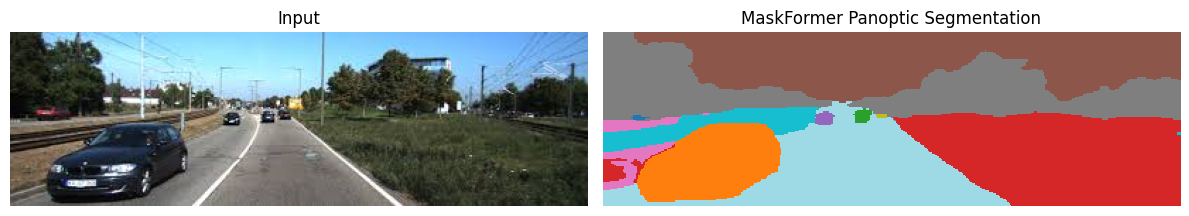

In [15]:
import torch
import time

# Make the SwinBackbone return hidden states (per-stage features)
seg_model.model.pixel_level_module.encoder.config.output_hidden_states = True
seg_model.model.pixel_level_module.encoder.config.return_dict = True

quant_mode = "fp16"  

if quant_mode == "fp16":
    # Option 1: FP16 (current approach) – keeps execution on GPU
    seg_model_half = seg_model.half().eval()
    inputs_half = seg_processor(images=image1, return_tensors="pt")
    inputs_half = {
        k: (v.to(seg_model_half.device).half() if isinstance(v, torch.Tensor) else v)
        for k, v in inputs_half.items()
    }


# Warmup runs
with torch.no_grad():
    for _ in range(5):
        _ = seg_model_half(**inputs_half)
torch.cuda.synchronize()

# Capture backbone features with hook
_captured = {}
def _enc_hook(_m, _in, out):
    _captured["bb_out"] = out

# Register hook and run inference
_h = seg_model_half.model.pixel_level_module.encoder.register_forward_hook(_enc_hook)

with torch.no_grad():
    seg_outputs = seg_model_half(**inputs_half)
    
_h.remove()  # Remove hook

# Benchmark inference time
runs = 20
t0 = time.perf_counter()
with torch.no_grad():
    for _ in range(runs):
        _ = seg_model_half(**inputs_half)
torch.cuda.synchronize()
t1 = time.perf_counter()

avg_ms = (t1 - t0) * 1000.0 / runs
fps = 1000.0 / avg_ms
print(f"Inference avg: {avg_ms:.2f} ms/img ({fps:.2f} FPS) over {runs} runs")

# Access captured backbone features
bb_out = _captured["bb_out"]
print("Hidden states shapes:", [t.shape for t in bb_out.hidden_states])
print("Feature maps shapes:", [t.shape for t in bb_out.feature_maps])

# Get specific features
c1_tokens = bb_out.hidden_states[0]     # First stage tokens
c4_map = bb_out.feature_maps[-1]        # Last stage feature map

# Post-process for visualization, downsample final seg map by 4
H, W = image1.size[::-1]
target = (H , W )
seg_result = seg_processor.post_process_panoptic_segmentation(
    outputs=seg_outputs, target_sizes=[target]
)[0]

# Visualize results
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(image1)
ax[0].set_title("Input")
ax[0].axis("off")

ax[1].imshow(seg_result["segmentation"].cpu(), cmap="tab20", interpolation="nearest")
ax[1].set_title("MaskFormer Panoptic Segmentation")
ax[1].axis("off")

plt.tight_layout()
plt.show()


In [16]:
seg_result["segmentation"].cpu().shape

torch.Size([123, 409])

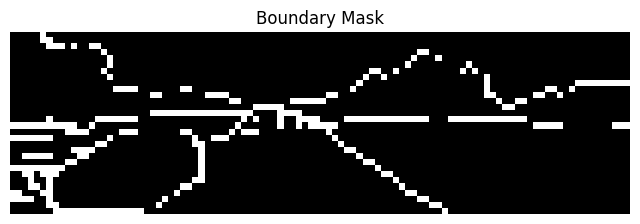

In [ ]:
## Compute boundary masks from seg_maps
import numpy as np
import cv2

def seg_to_boundary_mask(seg_map, dilate=2):
    """
    Compute boundary mask from segmentation map.
    Args:
        seg_map: HxW numpy array of integer segment IDs
        dilate: dilation radius in pixels (default=2)
    Returns:
        boundary_mask: HxW numpy array, 1 on boundaries, 0 elsewhere
    """
    h, w = seg_map.shape
    boundary_mask = np.zeros((h, w), dtype=np.uint8)

    # Check right and bottom neighbors for differences
    boundary_mask[:, :-1] |= (seg_map[:, :-1] != seg_map[:, 1:])  # right neighbor
    boundary_mask[:-1, :] |= (seg_map[:-1, :] != seg_map[1:, :])  # bottom neighbor

    # Dilate boundaries to make them thicker
    if dilate > 0:
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2 * dilate + 1, 2 * dilate + 1))
        boundary_mask = cv2.dilate(boundary_mask, kernel)

    return boundary_mask


boundary_mask = seg_to_boundary_mask(seg_result['segmentation'].cpu().numpy(), dilate=1)
## Downsample boundary mask by 4 for visualization
boundary_mask = cv2.resize(boundary_mask, (boundary_mask.shape[1]//4, boundary_mask.shape[0]//4), interpolation=cv2.INTER_NEAREST)
## Visualize boundary mask
plt.figure(figsize=(8,8))
plt.imshow(boundary_mask, cmap='gray')
plt.title("Boundary Mask")
plt.axis('off')
plt.show()

In [11]:
(bb_out.feature_maps[0].shape,  # (B, 128, H/4, W/4) for Swin-B
bb_out.feature_maps[1].shape , # (B, 256, H/8, W/8) for Swin-B
bb_out.feature_maps[2].shape ,# (B, 512, H/16, W/16) for Swin-B
bb_out.feature_maps[3].shape) # (B, 1024, H/32, W/32) for Swin-B

(torch.Size([1, 96, 96, 96]),
 torch.Size([1, 192, 48, 48]),
 torch.Size([1, 384, 24, 24]),
 torch.Size([1, 768, 12, 12]))

In [ ]:
## Dwona

## Testing SegFormer model

In [133]:
from transformers import SegformerImageProcessor, SegformerForSemanticSegmentation
from PIL import Image
import requests
import torch
from pathlib import Path

seg_model_name = "nvidia/segformer-b0-finetuned-ade-512-512"
processor = SegformerImageProcessor.from_pretrained(seg_model_name)
model = SegformerForSemanticSegmentation.from_pretrained(seg_model_name)
model.eval().to(torch.device('cuda'))

# image1 = Image.open("datasets/mono/ME001/000000.png").convert("RGB") ## Park/Tree/Day/Sunny
# image1 = Image.open("datasets/mono/ME000/000001.png").convert("RGB") ## Abonded Building terrace/ Day/very Sunny/glare
# image1 = Image.open("datasets/mono/ME002/000011.png").convert("RGB") ## cave/forest/dark
# image1 = Image.open("datasets/mono/ME003/000027.png").convert("RGB") ## suburban area/road/car/house
# image1 = Image.open("datasets/mono/ME004/000020.png").convert("RGB") ## underwater
image1 = Image.open("datasets/mono/ME005/000050.png").convert("RGB") ## indoor offfice
# image1 = Image.open("datasets/mono/ME006/000021.png").convert("RGB") ## dense forest
# image1 = Image.open("datasets/mono/ME007/000021.png").convert("RGB") ## desert
# image1 = Image.open('/home/user/Desktop/DPVO/conf_map_demo/KITTI_sample.png').convert("RGB")
image = image1
inputs = processor(images=image, return_tensors="pt").to(model.device)
outputs = model(**inputs)
logits = outputs.logits 

save_dir = f"seg_models/{seg_model_name}"
Path(save_dir).mkdir(parents=True, exist_ok=True)

_prev_device = next(model.parameters()).device
model.to("cpu")
model.save_pretrained(save_dir)
processor.save_pretrained(save_dir)
model.to(_prev_device)


/home/user/anaconda3/envs/dpvo118_backup/lib/python3.10/site-packages/transformers/image_processing_base.py:417: UserWarning: The following named arguments are not valid for `SegformerImageProcessor.__init__` and were ignored: 'feature_extractor_type', 'reduce_labels'
  image_processor = cls(**image_processor_dict)


SegformerForSemanticSegmentation(
  (segformer): SegformerModel(
    (encoder): SegformerEncoder(
      (patch_embeddings): ModuleList(
        (0): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(3, 32, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
          (layer_norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        )
        (1): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
        (2): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(64, 160, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((160,), eps=1e-05, elementwise_affine=True)
        )
        (3): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(160, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  

In [134]:
seg_outputs = processor.post_process_semantic_segmentation(outputs, target_sizes=[image.size[::-1]])[0]

In [135]:
seg_outputs.shape

torch.Size([480, 640])

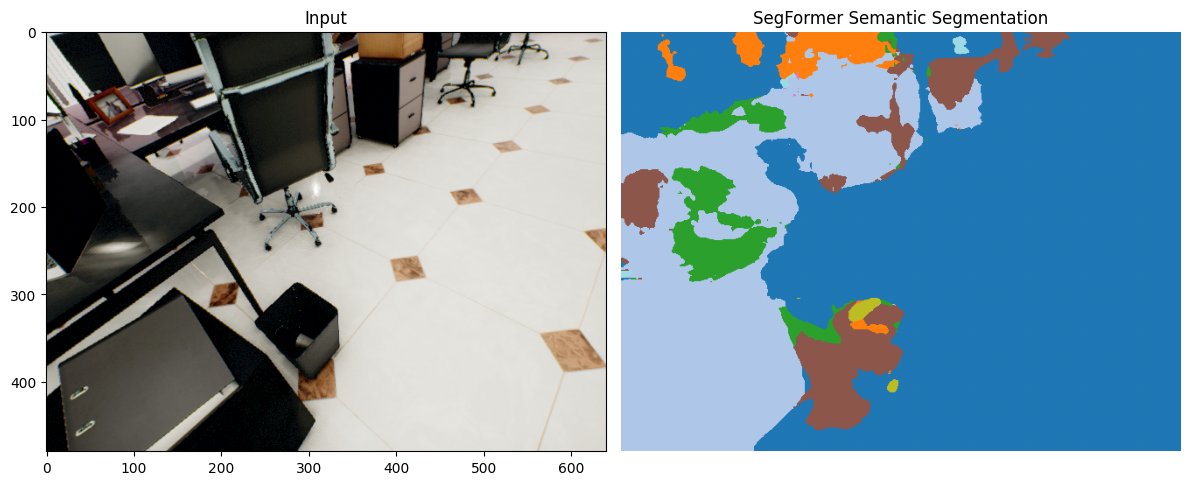

In [136]:
## Visualize results
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(image)
ax[0].set_title("Input")    
ax[1].imshow(seg_outputs.cpu().detach().numpy(), cmap="tab20")
ax[1].set_title("SegFormer Semantic Segmentation")
ax[1].axis("off")
plt.tight_layout()
plt.show()

In [137]:
## Testing inference speed
warmup = 5
runs = 20
with torch.no_grad():
    for _ in range(warmup):
        _ = model(**inputs)

torch.cuda.synchronize()
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)
start.record()
with torch.no_grad():
    for _ in range(runs):
        _ = model(**inputs)
end.record()
torch.cuda.synchronize()
print(f"Inference avg: {start.elapsed_time(end)/runs:.2f} ms/img")

Inference avg: 2.84 ms/img


# Capture encoder embeddings and final segmentation outputs
This section shows two ways to obtain backbone embeddings (encoder outputs) and the final segmentation logits:
- Use the model's `output_hidden_states=True` to get per-stage tokens.
- Register forward hooks to capture per-stage tokens and spatial shapes, then reshape to feature maps.

In [50]:
#
import torch
from typing import Dict, Tuple
try:
    model  # type: ignore[name-defined]
    processor  # type: ignore[name-defined]
except NameError:
    from transformers import SegformerForSemanticSegmentation, SegformerImageProcessor
    seg_model_name = "nvidia/segformer-b3-finetuned-ade-512-512"
    processor = SegformerImageProcessor.from_pretrained(seg_model_name)
    model = SegformerForSemanticSegmentation.from_pretrained(seg_model_name)
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

img = image1

inputs = processor(images=img, return_tensors="pt")
pixel_values = inputs["pixel_values"].to(device)

# 1) Built-in: request hidden states
with torch.no_grad():
    out_built_in = model(pixel_values=pixel_values, output_hidden_states=True, return_dict=True)
    final_logits = out_built_in.logits  # (B, num_labels, H_out, W_out)
    encoder_tokens = out_built_in.hidden_states  # tuple of 4: (B, H_i*W_i, C_i)

# 2) Forward hooks: capture tokens after each encoder stage and spatial shapes from patch embeddings
features: Dict[str, torch.Tensor] = {}  # stage -> (B, H_i*W_i, C_i)
shapes: Dict[str, Tuple[int, int]] = {}  # stage -> (H_i, W_i)
handles = []

def make_ln_hook(stage_idx):
    def hook(module, inp, out):
        features[f"stage{stage_idx}"] = out.detach()
    return hook

def make_pe_hook(stage_idx):
    def hook(module, inp, out):
        if isinstance(out, (tuple, list)) and len(out) == 3:
            _, H, W = out
            shapes[f"stage{stage_idx}"] = (int(H), int(W))
    return hook

# Register hooks for the 4 encoder stages
for i in range(4):
    handles.append(model.segformer.encoder.patch_embeddings[i].register_forward_hook(make_pe_hook(i)))
    handles.append(model.segformer.encoder.layer_norm[i].register_forward_hook(make_ln_hook(i)))

with torch.no_grad():
    _ = model(pixel_values=pixel_values)

for h in handles:
    h.remove()

def tokens_to_fmap(tokens: torch.Tensor, H: int, W: int) -> torch.Tensor:
    B, HW, C = tokens.shape
    assert HW == H * W, f"H*W mismatch: {HW} != {H*W}"
    return tokens.view(B, H, W, C).permute(0, 3, 1, 2).contiguous()

# Convert captured stages to feature maps when shapes are available
stage_fmaps: Dict[str, torch.Tensor] = {}
for i in range(4):
    key = f"stage{i}"
    if key in features and key in shapes:
        H, W = shapes[key]
        stage_fmaps[key] = tokens_to_fmap(features[key], H, W)

# Show quick summary
summary = {
    "final_logits": tuple(final_logits.shape),
    "encoder_tokens_shapes": [tuple(t.shape) for t in encoder_tokens],
    "hook_token_shapes": {k: tuple(v.shape) for k, v in features.items()},
    "hook_fmap_shapes": {k: tuple(v.shape) for k, v in stage_fmaps.items()},
}
print(summary)

# Expose convenient variables for later cells
seg_outputs = final_logits  # (B, num_labels, H_out, W_out)
backbone_tokens = encoder_tokens  # tuple of 4 (B, H_i*W_i, C_i)
backbone_feature_maps = stage_fmaps  # dict stage{i}: (B, C_i, H_i, W_i)

{'final_logits': (1, 150, 128, 128), 'encoder_tokens_shapes': [(1, 64, 128, 128), (1, 128, 64, 64), (1, 320, 32, 32), (1, 512, 16, 16)], 'hook_token_shapes': {'stage0': (1, 16384, 64), 'stage1': (1, 4096, 128), 'stage2': (1, 1024, 320), 'stage3': (1, 256, 512)}, 'hook_fmap_shapes': {'stage0': (1, 64, 128, 128), 'stage1': (1, 128, 64, 64), 'stage2': (1, 320, 32, 32), 'stage3': (1, 512, 16, 16)}}


In [11]:
import pickle
with open('/home/user/Desktop/DPVO/datasets/TartanAir.pickle','rb') as f :
    tartan_data = pickle.load(f)


In [13]:
tartan_data[0]

{}